In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D, LayerNormalization
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Add, Multiply, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
corpus = []
for text in x_train:
    corpus.append(text)
print(len(corpus))
for text in x_val:
    corpus.append(text)
print(len(corpus))

41997
45777


In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(corpus, x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
#dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab.keys())

55100

# Domain Specific Fasttext Embeddings

In [13]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.complete.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

53723
Total time taken:  5.202020721


(55101, 300)

In [14]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  55101
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# Self-Attention Architecture

In [15]:
class MultiHeadSelfAttention(Layer):
    
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

        
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    
    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [16]:
class TransformerBlock(Layer):
    
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

        
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [17]:
class TokenAndPositionEmbedding(Layer):
    
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [18]:
embed_dim = 300  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 300  # Hidden layer size in feed forward network inside transformer

In [23]:
inputs = Input(shape=(input_len,))
x = TokenAndPositionEmbedding(input_len, input_dim1, embedding_dim1)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
token_and_position_embedding (None, 100, 300)          16560300  
_________________________________________________________________
transformer_block_1 (Transfo (None, 100, 300)          543000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          439296    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260 

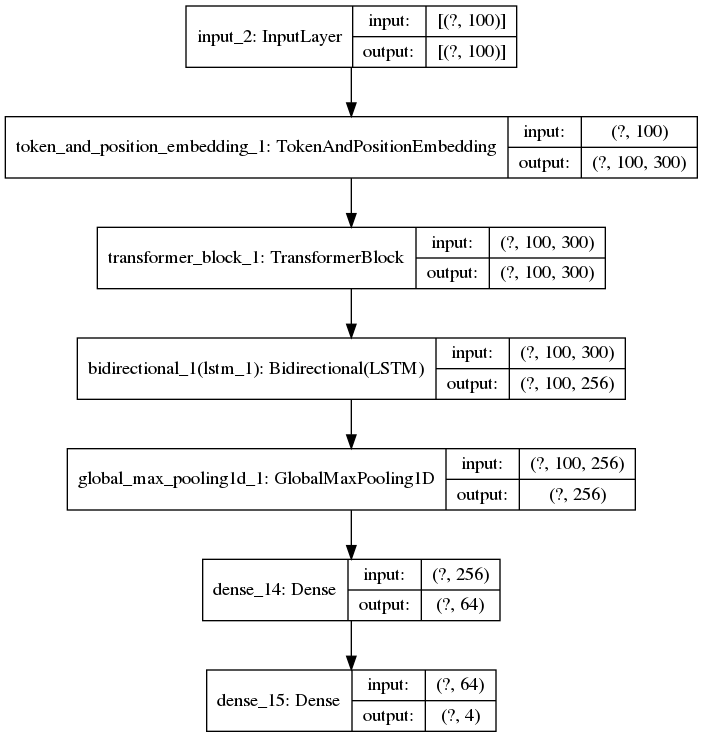

In [24]:
plot_model(model, show_shapes=True)

In [25]:
# ModelCheckPoint Callback:
checkpoint_filepath = "self-attention-LSTM.epoch-{epoch:02d}.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_freq = 'epoch',
                                            save_best_only=True)

# Reduce Learning Rate on Plateau Callback:
reduce_lr_callback = ReduceLROnPlateau( monitor='val_accuracy', 
                                       factor=0.2, 
                                       patience=2, 
                                       min_lr=0.0005, 
                                       verbose=2)
#myCB = myCallbacks(metrics='acc', threshold=0.97)

In [26]:
history = model.fit(x_train_padded, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    verbose=1,
                    validation_data=(x_val_padded, y_val),
                    callbacks=[model_checkpoint_callback, reduce_lr_callback])

Epoch 1/4
329/329 [==============================] - 596s 2s/step - loss: 0.7045 - accuracy: 0.7162 - val_loss: 0.3887 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 2/4
329/329 [==============================] - 568s 2s/step - loss: 0.2347 - accuracy: 0.9190 - val_loss: 0.3868 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 3/4
329/329 [==============================] - 569s 2s/step - loss: 0.1141 - accuracy: 0.9612 - val_loss: 0.4602 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 4/4
329/329 [==============================] - 569s 2s/step - loss: 0.0747 - accuracy: 0.9751 - val_loss: 0.5098 - val_accuracy: 0.8635 - lr: 0.0010


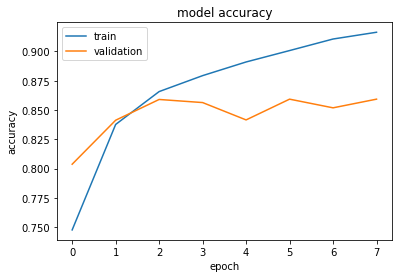

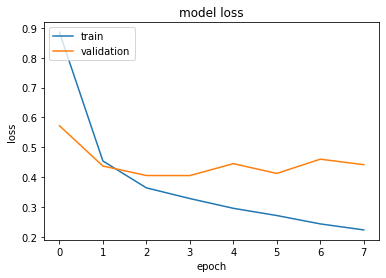

In [51]:
plot_curves(history)

In [52]:
results = np.argmax(classifier.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8592592592592593

Precision:  [0.83244681 0.85525488 0.87299771 0.8639745 ]
Average Precision:  0.8561684731700703

Recall:  [0.7452381  0.90299003 0.86214689 0.83814433]
Average Recall:  0.8371298377532402

F1-Score:  [0.78643216 0.87847447 0.86753837 0.85086342]
Average F1-Score:  0.8458271059704886


In [27]:
#save_model(classifier, "BiLSTM-CNN-Attention/BiLSTM-CNN-Attention-f1-8658")

Confusion matrix, without normalization


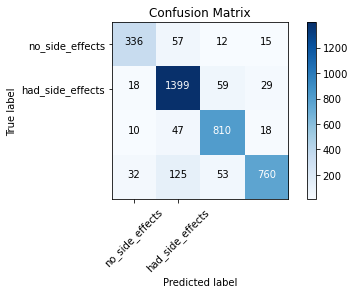

In [26]:
plot_confusion_matrix(y_val, 
                      results2, 
                      classes=['no_side_effects','had_side_effects'], 
                      title='Confusion Matrix',
                      normalize=False)